In [1]:
!nvidia-smi

Wed Apr 15 17:04:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   30C    P8     6W / 180W |      1MiB / 16278MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install & import dependencies

In [2]:
!pip install torchtext --upgrade > /dev/null 2>&1
!pip install spacy > /dev/null 2>&1
!python -m spacy download fr > /dev/null 2>&1
!python -m spacy download en > /dev/null 2>&1

In [2]:
import os
import re
import tqdm
import random
import unicodedata
import numpy as np
import matplotlib.pyplot as plt

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Example, Field, Dataset
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score

In [3]:
seed = 781
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


# Download data

In [4]:
if not os.path.exists('./data'):
    !mkdir ./data

In [8]:
%%time
!wget --no-check-certificate \
    http://www.statmt.org/europarl/v7/fr-en.tgz \
    -O ./data/fr-en.tgz

--2020-04-06 16:33:35--  http://www.statmt.org/europarl/v7/fr-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202718517 (193M) [application/x-gzip]
Saving to: ‘./data/fr-en.tgz’

./data/fr-en.tgz    100%[===================>] 193.33M  32.5KB/s    in 25m 0s  

2020-04-06 16:58:35 (132 KB/s) - ‘./data/fr-en.tgz’ saved [202718517/202718517]

CPU times: user 23.2 s, sys: 5.91 s, total: 29.1 s
Wall time: 25min


In [9]:
%%time
!tar -xzvf ./data/fr-en.tgz -C ./data

europarl-v7.fr-en.en
europarl-v7.fr-en.fr
CPU times: user 51.3 ms, sys: 42 ms, total: 93.3 ms
Wall time: 5.2 s


# Data processing

In [5]:
def read_file(filepath):
    try:
        with open(filepath, mode='rt', encoding='utf-8') as file:
            content = file.readlines()
        return content
    except:
        raise Error(f'File {filepath} doesn\'t exist')

In [32]:
def unicode_to_ascii(s):
    # NFD => Normal Form Decompose
    # Mn => Non Marking Space
    return ''.join(c for c in unicodedata.normalize('NFD', s) \
                    if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    # Transform accented characters into unaccented ones
    s = unicode_to_ascii(s.strip())
    # Replace any of '.', '!', '?' by ' .', ' !', ' ?'. \1 means the 1st bracked group. r is to not consider \1
    s = re.sub(r'([,.!?0-9])', r' \1', s)
    # Remove any character which is not in [^a-zA-Z0-9,.!?]
    s = re.sub(r'[^a-zA-Z0-9,.!?]', r' ', s)
    # Remove a sequence of whitespace characters
    s = re.sub(r'\s+', r' ', s)
    return s.strip()

In [34]:
normalize_string('L\'année 2019 était fabuleuse!')

'L annee 2 0 1 9 etait fabuleuse !'

In [35]:
%%time
pairs = [*zip(read_file('./data/europarl-v7.fr-en.fr'),
              read_file('./data/europarl-v7.fr-en.en'))]
pairs = [*map(lambda x: {'fr': x[0], 'en': x[1]}, pairs)]
print(f'Number of examples: {len(pairs):,}')

Number of examples: 2,007,723
CPU times: user 3.49 s, sys: 734 ms, total: 4.22 s
Wall time: 4.21 s


We do not build models the entire dataset, since is very large. Instead, I sample a subset of 100,000 sentence pairs.

In [36]:
%%time
pairs = np.random.choice(pairs, size=100000, replace=False)
pairs = [*map(lambda pair: {k: normalize_string(v) for k, v in pair.items()},
              pairs)]
print(f'Number of examples after sampling: {len(pairs):,}')
print(f'Example:\n\tFR => {pairs[0]["fr"]}\n\tEN => {pairs[0]["en"]}')

Number of examples after sampling: 100,000
Example:
	FR => Il est tendancieux et ne reflete pas la situation de menace reelle associee au trafic illegal de substances nucleaires au sein de l Union europeenne .
	EN => It is tendentious and does not match up to the real threat posed by illicit traffic in nuclear materials in the European Union .
CPU times: user 13.9 s, sys: 59.1 ms, total: 14 s
Wall time: 14 s


Now, we split data in train, valid and test sets.

In [37]:
FR = Field(init_token='<sos>',
           eos_token='<eos>',
           preprocessing=lambda x: x[::-1],
           lower=True,
           tokenize='spacy',
           tokenizer_language='fr',
           include_lengths=True) # For pack_padded_sequence
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='en')

MAX_LENGTH = 30

examples = [Example.fromdict(data=pair, fields={'fr': ('src', FR),
                                                'en': ('dest', EN)})
            for pair in tqdm.tqdm(pairs)]
examples = [*filter(lambda example: len(example.src) <= MAX_LENGTH and len(example.dest) <= MAX_LENGTH, examples)]
print(f'Number of examples after filtering: {len(examples):,}')

100%|██████████| 100000/100000 [00:30<00:00, 3318.42it/s]


Number of examples after filtering: 56,089


In [38]:
data = Dataset(examples, fields={'src': FR, 'dest': EN})
train_data, valid_data, test_data = data.split(split_ratio=[0.8, 0.1, 0.1])
print(f'train set size: {len(train_data.examples)}')
print(f'valid set size: {len(valid_data.examples)}')
print(f'test set size: {len(test_data.examples)}')
print(vars(train_data.examples[0]))

train set size: 44871
valid set size: 5609
test set size: 5609
{'src': ['.', 'europeenne', 'integration', 'd', 'processus', 'au', 'peu', 'tres', 'identifient', 's', 'europeens', 'citoyens', 'les', 'que', 'fait', 'le', 'sur', 'porte', 'longuement', 'a', 'debat', 'le'], 'dest': ['much', 'was', 'said', 'during', 'the', 'debate', 'on', 'the', 'programme', 'about', 'how', 'little', 'the', 'citizens', 'identify', 'with', 'the', 'process', 'of', 'european', 'integration', '.']}


Since the model understands only number, we need to transform text sequences into sequence of numbers where each numbers represents a unique token. To do this, we build a vocabulary for each language that map words to indexes and vice versa. the vocabulary id built from train set only in order to prevent data leakage. We also add some special tokens:
- `<sos>`: for start of sentence.
- `<unk>`: for unknown or less frequent words.
- `<eos>`: for end of sentence. 
- `<pad>`: for padding (make all sentences in a batch the same size). 

In [40]:
%%time
MIN_COUNT = 5
FR.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
EN.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])

print(f'Length of FR vocabulary: {len(FR.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of FR vocabulary: 7,726
Length of EN vocabulary: 6,468
CPU times: user 616 ms, sys: 0 ns, total: 616 ms
Wall time: 616 ms


# Modeling

The goal is to find the best english sentence $y$ that maximize the likelihood given a french sentence $x$, $P(y|x)$. To do this, we trained a neural probabilistic sequence-to-sequence model.

## Encoder

The part of model map the source sequence to hidden vector (encoding).

In [44]:
class Encoder(nn.Module):
    
    def __init__(self, embedding_size, vocab_size, hidden_size, n_layers, dropout, recurrent_dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        
    def forward(self, input_sequences, sequence_lengths):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            
        :return
            outputs: Tensor[seq_len, batch_size, hidden_size]
            hn: Tensor[num_layers, batch_size, hidden_size]
            cn: Tensor[num_layers, batch_size, hidden_size]
        """
        embedded = self.embedding(input_sequences)
        embedded = self.dropout(embedded)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, sequence_lengths)
        outputs, (hn, cn) = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        return outputs, hn, cn

## Decoder

The part of model performs a conditional language modeling given the hidden vector outputs by the encoder.

In [45]:
class Decoder(nn.Module):

    def __init__(self, embedding_size, vocab_size, hidden_size, n_layers, dropout, recurrent_dropout):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input_word_index, h_state, c_state):
        """
        :params
            input_word_index: Tensor[batch_size,]
            h_state: Tensor[num_layers, batch_size, hidden_size]
            c_state: Tensor[num_layers, batch_size, hidden_size]
            
        :return
            logit: Tensor[batch_size, vocab_size]
            h_state: Tensor[num_layers, batch_size, hidden_size]
            c_state: Tensor[num_layers, batch_size, hidden_size]
        """
        embedded = self.embedding(input_word_index.unsqueeze(0))
        embedded = self.dropout(embedded)
        outputs, (h_state, c_state) = self.lstm(embedded, (h_state, c_state))
        # outputs: [1, batch_size, hidden_size]
        logit = self.fc(outputs.squeeze(0))
        return logit, h_state, c_state

## Sequence to sequence model

This puts encoder and decoder together.

In [46]:
class SeqToSeqNet(nn.Module):

    def __init__(self, encoder, decoder, device):
        assert encoder.n_layers == decoder.n_layers, 'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, 'Encoder and Decoder must have the same number of reccurrent hidden units'

        super(SeqToSeqNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, input_sequences, sequence_lengths, target_sequences, tf_ratio):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            target_sequences: Tensor[seq_len, batch_size]
            tf_ratio: float
            
        :return
            outputs: Tensor[seq_len - 1, batch_size, vocab_size]
                Since we ignore the SOS_TOKEN
        """
        _, h_state, c_state = self.encoder(input_sequences, sequence_lengths)
        
        seq_len, batch_size = target_sequences.size()
        outputs = torch.zeros(seq_len - 1, batch_size, self.decoder.vocab_size).to(self.device)
        word_index = target_sequences[0, :]
        
        for t, idx in enumerate(range(1, seq_len)):
            output, h_state, c_state = self.decoder(word_index, h_state, c_state)
            # output: [batch_size, vocab_size]
            outputs[t] = output
            
            if random.random() < tf_ratio:
                word_index = target_sequences[idx, :]
            else:
                word_index = output.argmax(dim=1)
                
        return outputs

# Training routines

In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [48]:
def plot_gradient_flow(named_parameters):
    grad_mean, layers = [], []
    for name, param in named_parameters:
        if param.requires_grad and 'bias' not in name:
            layers.append(name)
            grad_mean.append(param.grad.abs().mean())
    plt.plot(grad_mean, alpha=0.3, color='b')
    plt.hlines(0, 0, len(grad_mean) + 1, linewidth=1, color='k' )
    plt.xticks(range(0, len(grad_mean), 1), layers, rotation='vertical')
    plt.xlim(xmin=0, xmax=len(grad_mean))
    # plt.ylim(bottom=-0.001, top=0.02) # Zoom on lower gradients
    plt.xlabel('Layers')
    plt.ylabel('Mean of gradients')
    plt.title('Gradient Flow')
    plt.grid(True)

In [49]:
def train_epoch(model, opt, loss_func, tf_ratio, data_it, grad_clip, epoch_text):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.train()
    for i, data in pbar:
        opt.zero_grad()
        outputs = model(*data.src, data.dest, tf_ratio)
        # *data.src: unpack input_sequences and sequence_lengths
        loss = loss_func(outputs.view(-1, model.decoder.vocab_size), data.dest[1:].view(-1))
        loss.backward()
        # plot_gradient_flow(model.named_parameters())
        if grad_clip:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()
        epoch_loss += loss.item()
        pbar.set_description(epoch_text + f'loss:     {epoch_loss / (i + 1):.3f} - ppl:     {np.exp(epoch_loss / (i + 1)):7.3f}')
    # plt.show() # Show the gradient flow
    return epoch_loss / len(data_it), np.exp(epoch_loss / len(data_it))

In [50]:
def valid_epoch(model, loss_func, data_it, epoch_text):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.eval()
    with torch.no_grad():
        for i, data in pbar:
            outputs = model(*data.src, data.dest, 0) # Turn-off the teacher forcing
            loss = loss_func(outputs.view(-1, model.decoder.vocab_size), data.dest[1:].view(-1))
            epoch_loss += loss.item()
            pbar.set_description(epoch_text + f'val_loss: {epoch_loss / (i + 1):.3f} - val_ppl: {np.exp(epoch_loss / (i + 1)):7.3f}')
    return epoch_loss / len(data_it), np.exp(epoch_loss / len(data_it))

In [52]:
def train(model, opt, loss_func, train_it, valid_it, tf_ratio, n_epochs, grad_clip, save_to, filename):
    assert callable(loss_func)
    if not os.path.exists(save_to):
        !mkdir {save_to}
    
    history = {
        'loss': [],
        'val_loss': [],
        'ppl': [],
        'val_ppl': []
    }
    best_loss = [float('inf')]
    for epoch in range(n_epochs):
        epoch_text = f'Epoch: {epoch + 1:02d} - '
        loss, ppl = train_epoch(model=model, opt=opt, loss_func=loss_func, tf_ratio=tf_ratio,
                                data_it=train_it, grad_clip=grad_clip, epoch_text=epoch_text)
        val_loss, val_ppl = valid_epoch(model=model, loss_func=loss_func, data_it=valid_it, epoch_text=epoch_text)
        
        history['loss'].append(loss)
        history['val_loss'].append(val_loss)
        history['ppl'].append(ppl)
        history['val_ppl'].append(val_ppl)
        
        # Reduce tf_ratio
        tf_ratio = tf_ratio - tf_ratio / (epoch + 2)
        
        # Saving
        if val_loss < best_loss[-1]:
            best_loss.append(val_loss)
            torch.save({
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': opt.state_dict()
            }, f=os.path.join(save_to, filename))
            
        # Stop training
        try:
            if val_loss > best_loss[-2]:
                print('Stop training because the loss is increasing!')
                break
        except IndexError:
            pass
        
    return history

# Define and train models

In [53]:
EMBEDDING_DIM = 128
HIDDEN_SIZE = 256
N_LAYERS = 2
DROPOUT = 0.15
RECURRENT_DROPOUT = 0.35
GRAD_CLIP = 1.0
BATCH_SIZE = 64
N_EPOCHS = 15
TF_RATIO = 0.5

In [54]:
train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=BATCH_SIZE,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True, # For pack_padded_sequence
                              device=device)

In [67]:
encoder = Encoder(embedding_size=EMBEDDING_DIM,
                  vocab_size=len(FR.vocab),
                  hidden_size=HIDDEN_SIZE,
                  n_layers=N_LAYERS,
                  dropout=DROPOUT,
                  recurrent_dropout=RECURRENT_DROPOUT).to(device)
decoder = Decoder(embedding_size=EMBEDDING_DIM,
                  vocab_size=len(EN.vocab),
                  hidden_size=HIDDEN_SIZE,
                  n_layers=N_LAYERS,
                  dropout=DROPOUT,
                  recurrent_dropout=RECURRENT_DROPOUT).to(device)
seq2seq = SeqToSeqNet(encoder=encoder,
                      decoder=decoder,
                      device=device).to(device)
opt_adam = optim.Adam(seq2seq.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=EN.vocab.stoi[EN.pad_token])
print(f'Number of parameters of the model: {count_parameters(seq2seq):,}')

Number of parameters of the model: 5,322,308


In [59]:
%%time
history = train(model=seq2seq,
                opt=opt_adam,
                loss_func=criterion,
                train_it=train_iterator,
                valid_it=valid_iterator,
                tf_ratio=TF_RATIO,
                n_epochs=N_EPOCHS,
                grad_clip=GRAD_CLIP,
                save_to='./saved_models',
                filename='seq2seq-baseline-lstm.pt')

Epoch: 15 - val_loss: 4.456 - val_ppl:  86.163: 100%|██████████| 88/88 [00:02<00:00, 30.45it/s]


CPU times: user 15min 24s, sys: 5min 2s, total: 20min 27s
Wall time: 12min 17s


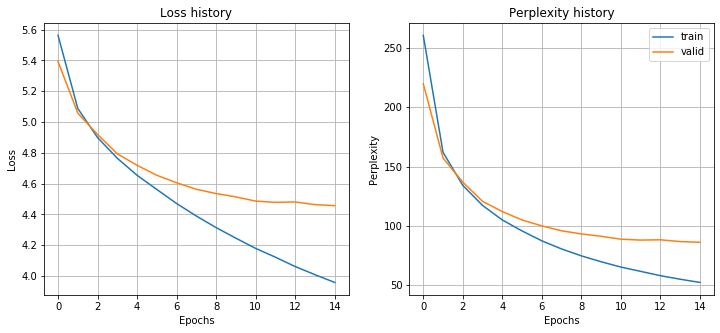

In [60]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[1].plot(history['ppl'], label='train')
axes[1].plot(history['val_ppl'], label='valid')
axes[1].set_title('Perplexity history')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
plt.legend()
plt.show()

In [68]:
seq2seq.load_state_dict(torch.load('./saved_models/seq2seq-baseline-lstm.pt').get('model'))

<All keys matched successfully>

In [73]:
val_loss, val_ppl = valid_epoch(model=seq2seq,
                                loss_func=criterion,
                                data_it=test_iterator,
                                epoch_text='Evaluation on test set - ')


  0%|          | 0/88 [00:00<?, ?it/s]
Evaluation on test set - val_loss: 4.649 - val_ppl: 104.510:   0%|          | 0/88 [00:00<?, ?it/s]
Evaluation on test set - val_loss: 3.207 - val_ppl:  24.695:   0%|          | 0/88 [00:00<?, ?it/s]
Evaluation on test set - val_loss: 2.972 - val_ppl:  19.522:   0%|          | 0/88 [00:00<?, ?it/s]
Evaluation on test set - val_loss: 2.913 - val_ppl:  18.415:   0%|          | 0/88 [00:00<?, ?it/s]
Evaluation on test set - val_loss: 2.913 - val_ppl:  18.415:   5%|▍         | 4/88 [00:00<00:02, 33.35it/s]
Evaluation on test set - val_loss: 2.950 - val_ppl:  19.110:   5%|▍         | 4/88 [00:00<00:02, 33.35it/s]
Evaluation on test set - val_loss: 3.048 - val_ppl:  21.080:   5%|▍         | 4/88 [00:00<00:02, 33.35it/s]
Evaluation on test set - val_loss: 3.089 - val_ppl:  21.952:   5%|▍         | 4/88 [00:00<00:02, 33.35it/s]
Evaluation on test set - val_loss: 3.169 - val_ppl:  23.779:   5%|▍         | 4/88 [00:00<00:02, 33.35it/s]
Evaluation on test s

# Inference

In [124]:
class Inference:
    
    def __init__(self, model, src_field, dest_field, normalizer, max_length, device):
        assert callable(normalizer)
        
        self.model = model
        self.src_field = src_field
        self.dest_field = dest_field
        self.normalizer = normalizer
        self.max_length = max_length
        self.device = device
    
    def encoder(self, sentence):
        sentence = self.normalizer(sentence)
        sentence = self.src_field.preprocess(sentence)
        input_sequence, sequence_length = self.src_field.process([sentence])
        input_sequence = input_sequence.to(self.device)
        sequence_length = sequence_length.to(self.device)
        _, h_state, c_state = self.model.encoder(input_sequence, sequence_length)
        return _, h_state, c_state
    
    def greedy(self, sentence):
        """
        Translate using Greedy method
        
        :param
            sentence: str
            
        :return 
        """
        _, h_state, c_state = self.encode(sentence)
        outputs, logp = [], 0
        word_index = torch.tensor([self.dest_field.vocab.stoi[self.dest_field.init_token]], device=self.device)
        for _ in range(self.max_length):
            output, h_state, c_state = self.model.decoder(word_index, h_state, c_state)
            probas = F.softmax(output, dim=1)
            proba, word_index = torch.topk(probas, k=1, dim=1)
            word_index = word_index.squeeze(0)
            if word_index.detach().item() == self.dest_field.vocab.stoi[self.dest_field.eos_token]:
                break
            outputs.append(word_index.detach().item())
            logp +=  np.log(proba.detach().item())
        return ' '.join([*map(self.dest_field.vocab.itos.__getitem__, outputs)]), logp
    
    def beam_search(self, sentence, beam_size):
        pass

In [125]:
translator = Inference(model=seq2seq,
                       src_field=FR,
                       dest_field=EN,
                       normalizer=normalize_string,
                       max_length=MAX_LENGTH,
                       device=device)

In [128]:
translator.greedy('Le parlement européen')

('parliament european parliament', -1.594740785338368)

In [144]:
for i in np.random.choice(len(test_data.examples), 10):
    s = ' '.join(test_data.examples[i].src[::-1])
    d = ' '.join(test_data.examples[i].dest)
    print(s)
    print('-'*100)
    print(translator.greedy(s))
    print('-'*100)
    print(d)
    print('='*100)

je soutiens le rapport klinz afin de contribuer au processus de reforme des agences de notation .
----------------------------------------------------------------------------------------------------
('i welcome the report report the the the the the the of of . . .', -26.211226817460478)
----------------------------------------------------------------------------------------------------
i support the klinz report in order to advance the process of reforming the rating agencies .
il ne faut pas seulement le proclamer , mais se donner les moyens de le mettre en ? uvre .
----------------------------------------------------------------------------------------------------
('we must not be to but but but but the to to the . .', -25.623090723833517)
----------------------------------------------------------------------------------------------------
we must not only talk about it we must give ourselves the means to implement it .
il n y a pas eu de position commune avant juin cette annee mais a